# Querying a JointDb: Visualizing Chromatin Structure and Epigenetic Signals in Breast Tissues

This notebook demonstrates how to use a `JointDb` HDF5 database created with `jointly-hic` to explore low-dimensional Hi-C embeddings and their relationship to epigenomic features, such as ChIP-seq signal tracks.

The data consists of Hi-C contact matrices generated from the experiments done by *Choppavarapu et al.* and ChIP-seq, ATAC-seq, DNase-seq, and RNA-seq experiments on the MCF-7 breast cancer cell line and healthy breast tissues from human donors. These datasets were curated from ENCODE and integrated into a structured database using `jointly-hic`.

## What You’ll Learn

- How to connect to a `JointDb` and inspect metadata
- How to query per-sample and full-cohort Hi-C embeddings (PCA/UMAP)
- How to visualize clustering results across biosamples
- How to overlay ChIP-seq signal intensity onto UMAP embeddings
- How to explore the genome browser-style relationship between:
  - PC-1 values (representing compartment structure)
  - ChIP-seq signals (e.g., H3K9me3 enrichment)
  - Genomic location (e.g., `chr1`)

## Key Concepts

- **Hi-C embeddings**: Capture large-scale 3D chromatin compartment structure.
- **UMAP and PCA**: Provide interpretable 2D projections for cluster visualization.
- **ChIP-seq and other assays (e.g., ATAC-seq)**: Allow direct correlation between structural chromatin states and histone modifications.
- **Per-chromosome plots**: Reveal relationships between compartment scores and histone marks.

## Requirements

This notebook assumes you have already:

1. Created a `JointDb.h5` file using `jointly hdf5db`
2. Prepared valid experiment and track metadata (YAML)
3. Included signal tracks in BigWig format, referenced via ENCODE accessions

## Output

The notebook generates several useful figures:

- PCA and UMAP plots, colored by clustering or chromosome
- ChIP-seq signal overlays for multiple histone marks
- Browser-style genomic line plots for PC-1 and histone signal (e.g., H3K27me3)
- Scatterplots illustrating anti-correlation between chromatin structure and repression

These visualizations provide an interactive and scalable way to interpret 3D genome structure in the context of epigenomic regulation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datashader as ds
import seaborn as sns
from datashader.mpl_ext import dsshow

from jointly_hic.hdf5db.hdf5db import JointDb

# Prepare for saving PDF files
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

In [2]:
# Connect a JointDb wrapper to the database
JOINTDB_FILE = "./data/breast-demo-jointdb.h5"
db = JointDb(JOINTDB_FILE)
db

JointDb(file='./data/breast-demo-jointdb.h5', bins=60630, experiments=12, tracks=252)

In [3]:
# View experiment metadata
db.experiment_metadata

accession biosample
0            Normal_breast1    normal
1            Normal_breast2    normal
2     Primary_breast_tumor1    cancer
3     Primary_breast_tumor2    cancer
4     Primary_breast_tumor3    cancer
5     Primary_breast_tumor4    cancer
6     Primary_breast_tumor5    cancer
7   Recurrent_breast_tumor1    cancer
8   Recurrent_breast_tumor2    cancer
9   Recurrent_breast_tumor3    cancer
10  Recurrent_breast_tumor4    cancer
11  Recurrent_breast_tumor5    cancer

In [4]:
# View track metadata
db.track_metadata

accession         assay   experiment biosample
0    ENCFF009GAZ  ChIP.H3K4me3  ENCSR000AML    normal
1    ENCFF011KML     ChIP.MBD2  ENCSR940MHE    cancer
2    ENCFF018UUW   ChIP.POLR2A  ENCSR000DMT    cancer
3    ENCFF020TLN     ChIP.MTA3  ENCSR391KQC    cancer
4    ENCFF033DSQ    ChIP.CTBP1  ENCSR636EYA    cancer
..           ...           ...          ...       ...
247  ENCFF981IVQ    ChIP.CEBPB  ENCSR000BSR    cancer
248  ENCFF990JEY           RNA  ENCSR020YQE    normal
249  ENCFF992MXL      ChIP.SP1  ENCSR729LGA    cancer
250  ENCFF995YMR      ChIP.NBN  ENCSR591EBL    cancer
251  ENCFF999WNF    ChIP.NFRKB  ENCSR248IMH    cancer

[252 rows x 4 columns]

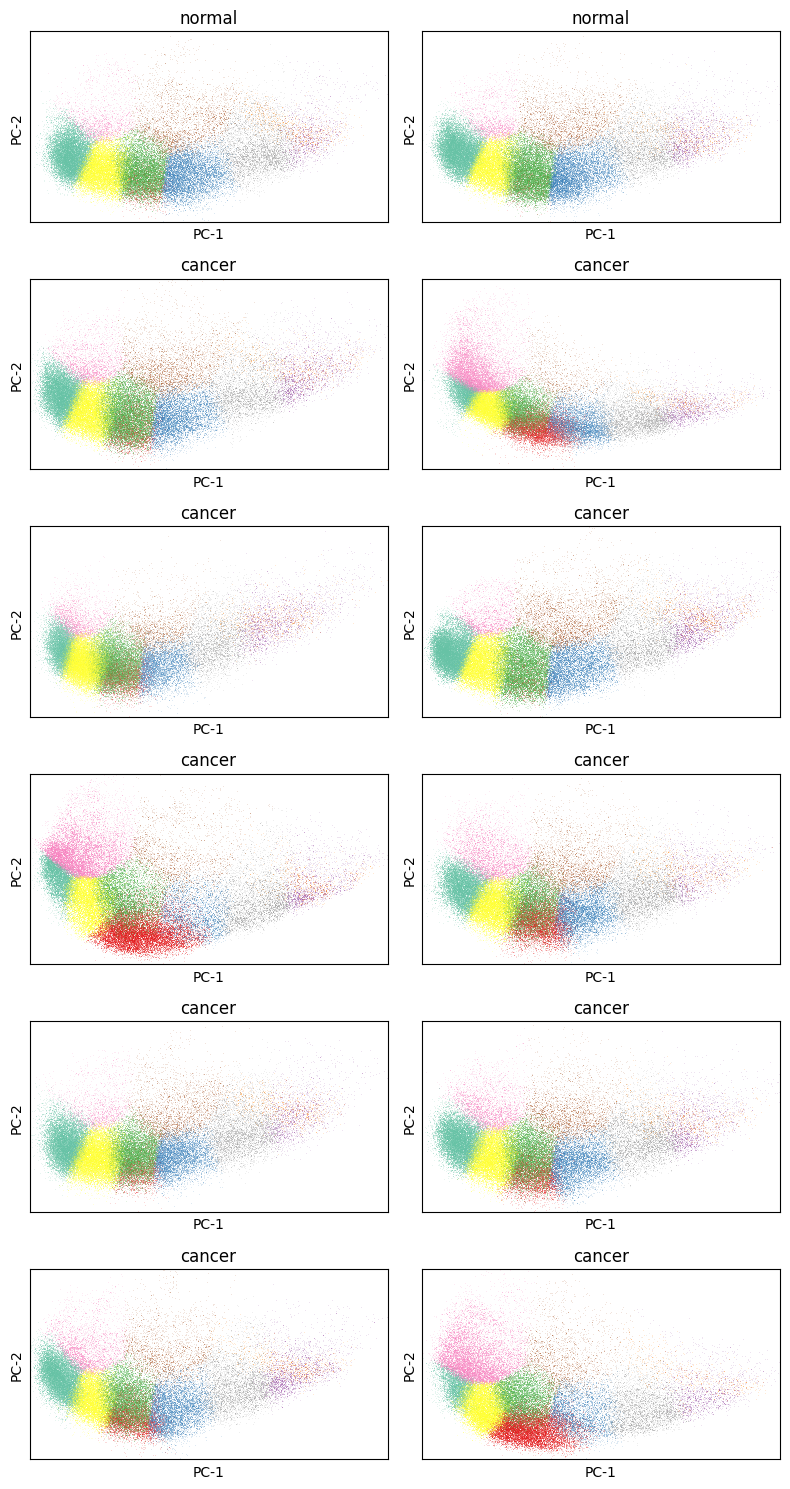

In [11]:
# Plot PCA embeddings for each sample, colored by kmeans_10 clusters
# There are 12 samples so let's organize them as nrows=6, ncols=2
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["PCA1", "PCA2", "kmeans_10"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "kmeans_10" to category & store as "cluster"
    embeddings["cluster"] = embeddings["kmeans_10"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")


plt.savefig("PCA-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

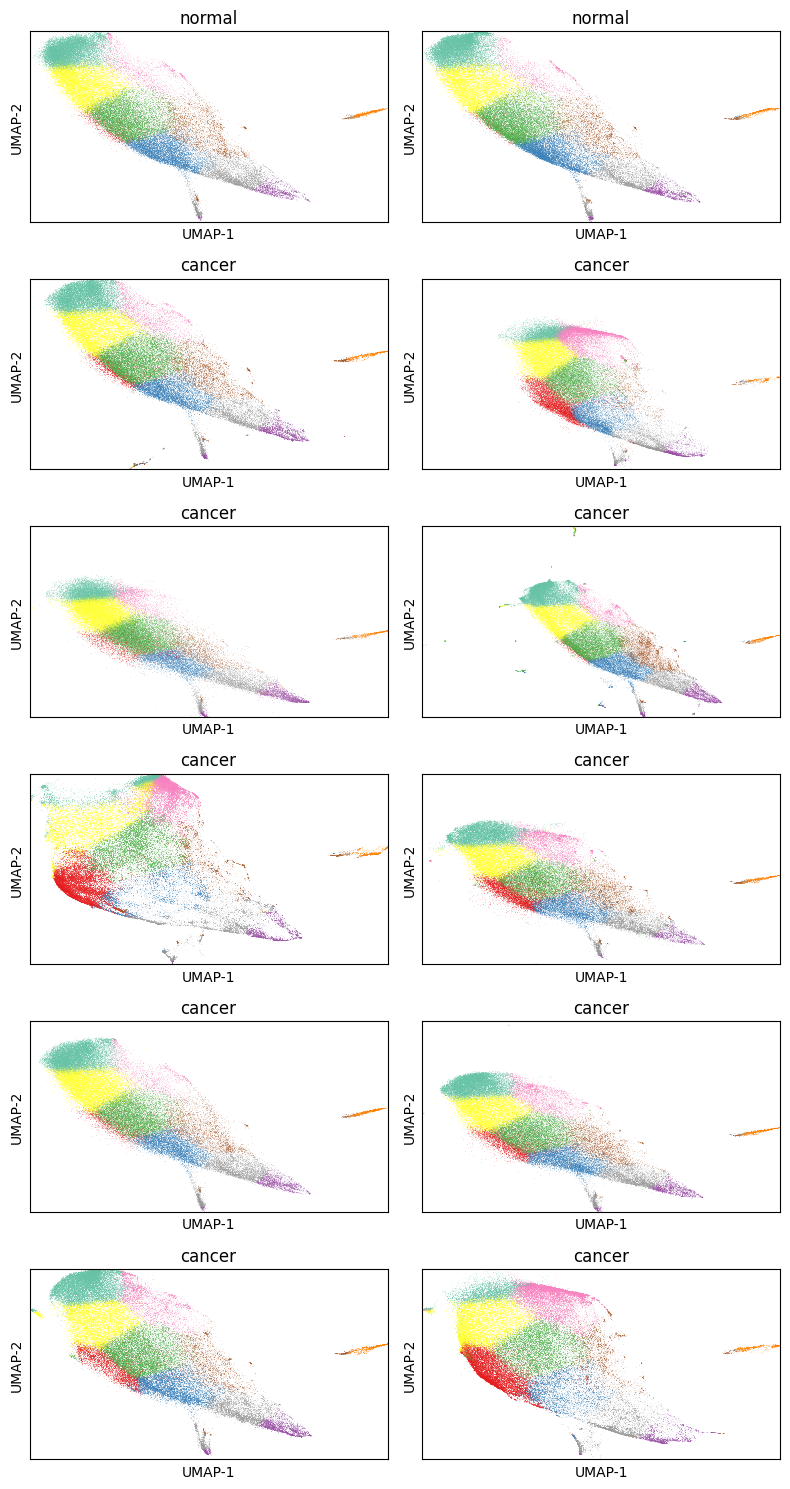

In [12]:
# Plot UMAP embeddings for each sample, colored by kmeans_10 clusters
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["umap1_n100", "umap2_n100", "kmeans_10"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "kmeans_10" to category & store as "cluster"
    embeddings["cluster"] = embeddings["kmeans_10"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.savefig("UMAP-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

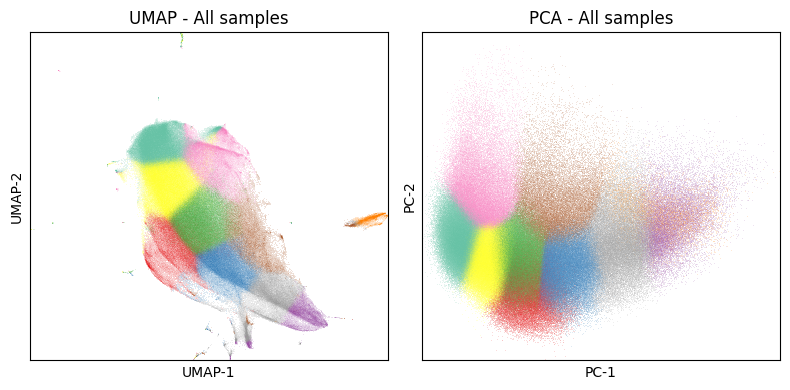

In [13]:
# Plot UMAP & PCA for all samples in one plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Query DB for data for this accession & embeddings
embeddings = db.get_embeddings(
    embeddings=["umap1_n100", "umap2_n100", "PCA1", "PCA2", "kmeans_10"],
    drop_bad_bins=True,
)

# Convert "kmeans_10" to category & store as "cluster"
embeddings["cluster"] = embeddings["kmeans_10"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[0],
)
axes[0].set_title("UMAP - All samples")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Plot PCA
im = dsshow(
    embeddings,
    ds.Point("PCA1", "PCA2"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[1],
)
axes[1].set_title("PCA - All samples")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel("PC-1")
axes[1].set_ylabel("PC-2")

plt.savefig("UMAP-PCA-all-samples.pdf", dpi=300)
plt.tight_layout()
plt.show()




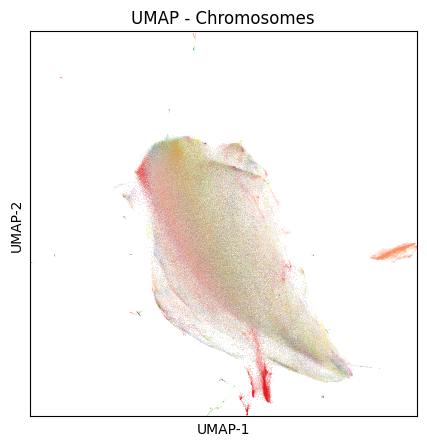

In [14]:
# The "stranded" aspect of the UMAP might be expalained by chromosome separation
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Filter to numerical chroms 1-22
embeddings = embeddings[
    embeddings["chrom"].isin([f"chr{i+1}" for i in range(22)])
].copy()

# Convert "chrom" to category & store as "chrom_cat"
embeddings["chrom_cat"] = embeddings["chrom"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("chrom_cat"),
    aspect="auto",
    ax=axis,
)
axis.set_title("UMAP - Chromosomes")
axis.set_xticks([])
axis.set_yticks([])
axis.set_xlabel("UMAP-1")
axis.set_ylabel("UMAP-2")
plt.show()

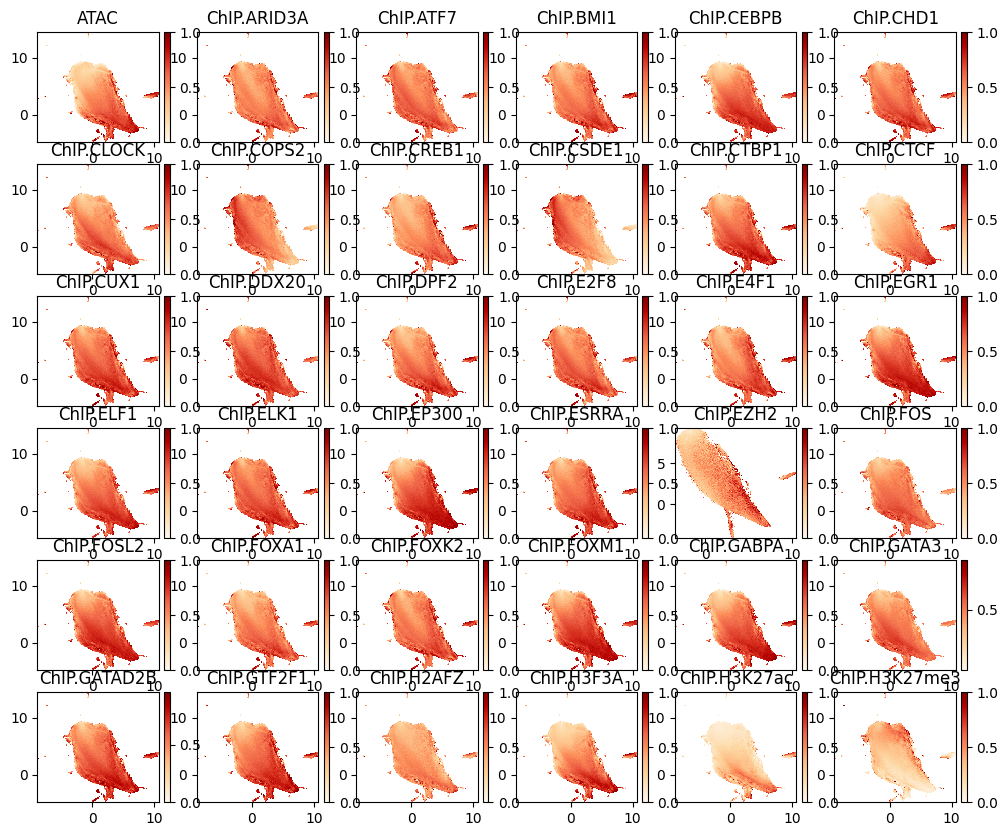

In [21]:
# Plot targets overlays
# Join ENCODE breast tissue metadata tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all targets


def scale_signal(df) -> pd.DataFrame:
    """
    Scale the signal data in a DataFrame by clipping outliers at the 0.05 and 0.95 quantiles,
    then normalizing to the [0, 1] range.

    Args:
        df (pd.DataFrame): DataFrame containing signal data to be scaled.

    Returns:
        pd.DataFrame: DataFrame with scaled signal data.
    """

    def clip_and_scale(x):
        lower = x.quantile(0.05)
        upper = x.quantile(0.95)
        x_clipped = x.clip(lower=lower, upper=upper)
        return (x_clipped - lower) / (upper - lower)

    df["signal"] = df.groupby("bw_accession")["signal"].transform(clip_and_scale)
    return df


# List of targets
targets = db.track_metadata.assay.unique()
targets.sort()

# Here shows the first 36 plots as an example 
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather sequencing data for the specified target and apply the scaler
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("UMAP-overlays.pdf", dpi=300)
plt.show()

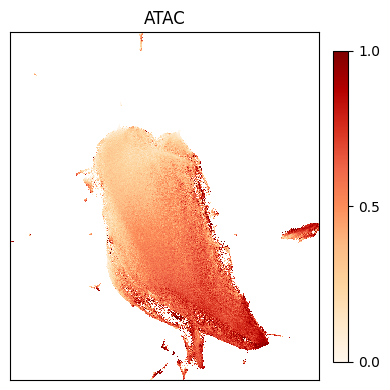

In [22]:
# Plot targets overlays
# Join ENCODE breast tissue metadata tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for only ATAC-seq

# Filter only ATAC-related targets
atac_targets = [t for t in db.track_metadata.assay.unique() if "ATAC" in t]
atac_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(atac_targets), figsize=(4 * len(atac_targets), 4))
if len(atac_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over ATAC targets
for ax, target in zip(axes, atac_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-ATAC.pdf", dpi=300)
plt.show()

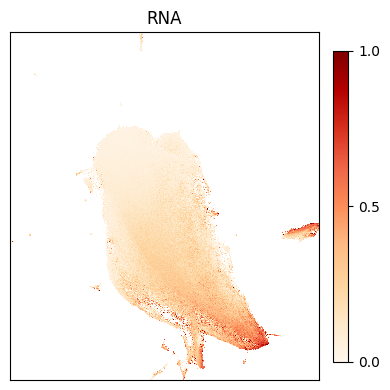

In [23]:
# Plot overlays for only RNA-seq
# Filter only RNA-related targets
rna_targets = [t for t in db.track_metadata.assay.unique() if "RNA" in t]
rna_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(rna_targets), figsize=(4 * len(rna_targets), 4))
if len(rna_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over RNA targets
for ax, target in zip(axes, rna_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-RNA.pdf", dpi=300)
plt.show()


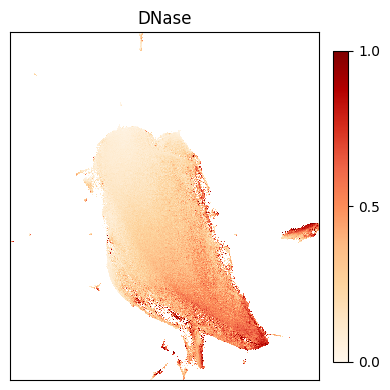

In [24]:
# Plot overlays for only DNase-seq
# Filter only DNase-related targets
dnase_targets = [t for t in db.track_metadata.assay.unique() if "DNase" in t]
dnase_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(dnase_targets), figsize=(4 * len(dnase_targets), 4))
if len(dnase_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over DNase targets
for ax, target in zip(axes, dnase_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-DNase.pdf", dpi=300)
plt.show()


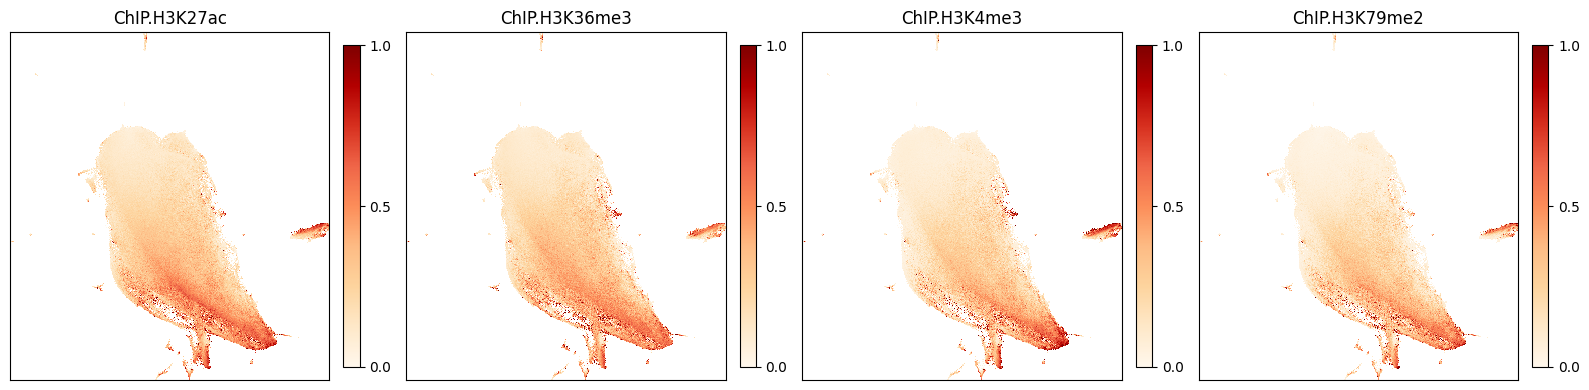

In [26]:
# Plot overlays for ChIP-seq assays for active chromatin marks (euchromatin)
# List of common active chromatin marks in ChIP-seq assays
active_chromatin_marks = ["H3K27ac", "H3K4me3", "H3K36me3", "H3K79me2"]

# Filter only ChIP-seq assays for active chromatin marks
chip_active_targets = [
    t for t in db.track_metadata.assay.unique() 
    if "ChIP" in t and any(mark in t for mark in active_chromatin_marks)
]
chip_active_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(chip_active_targets), figsize=(4 * len(chip_active_targets), 4))
if len(chip_active_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over ChIP-seq targets for active chromatin marks
for ax, target in zip(axes, chip_active_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-ChIP-active-chromatin.pdf", dpi=300)
plt.show()


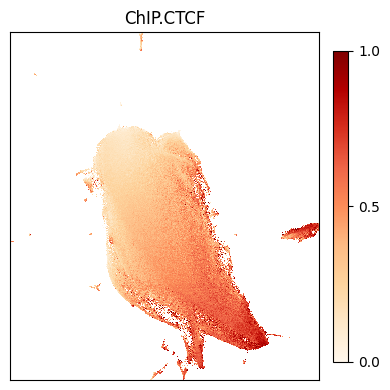

In [27]:
# Plot overlays for CTCF ChIP-seq
# Filter only CTCF ChIP-seq targets
ctcf_chip_targets = [
    t for t in db.track_metadata.assay.unique() 
    if "ChIP" in t and "CTCF" in t
]
ctcf_chip_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(ctcf_chip_targets), figsize=(4 * len(ctcf_chip_targets), 4))
if len(ctcf_chip_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over CTCF ChIP-seq targets
for ax, target in zip(axes, ctcf_chip_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-CTCF-ChIP-seq.pdf", dpi=300)
plt.show()


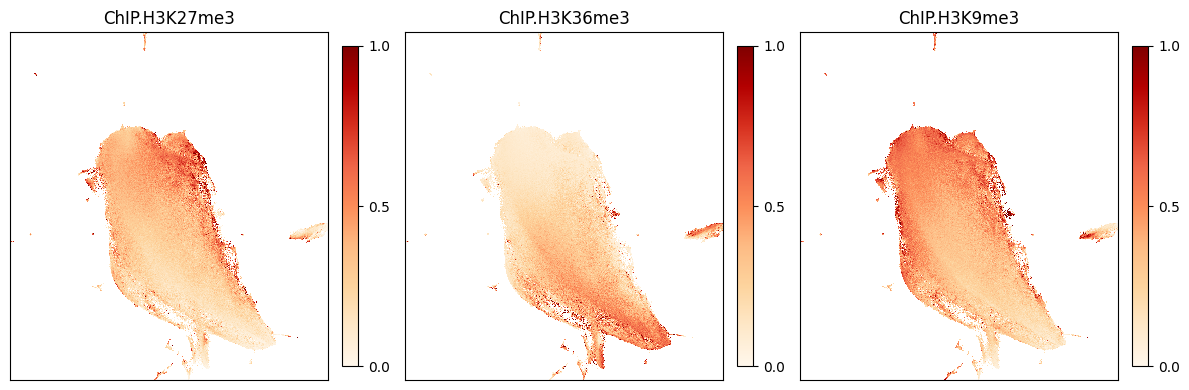

In [28]:
# Plot overlays for ChIP-seq assays for inactive chromatin marks (heterochromatin)
# List of common inactive chromatin marks in ChIP-seq assays
inactive_chromatin_marks = ["H3K27me3", "H3K9me3", "H3K36me3"]

# Filter only ChIP-seq assays for inactive chromatin marks
chip_inactive_targets = [
    t for t in db.track_metadata.assay.unique() 
    if "ChIP" in t and any(mark in t for mark in inactive_chromatin_marks)
]
chip_inactive_targets.sort()

fig, axes = plt.subplots(nrows=1, ncols=len(chip_inactive_targets), figsize=(4 * len(chip_inactive_targets), 4))
if len(chip_inactive_targets) == 1:
    axes = [axes]  # Make iterable if only one target

# Iterate over ChIP-seq targets for inactive chromatin marks
for ax, target in zip(axes, chip_inactive_targets):
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("UMAP-overlays-ChIP-inactive-chromatin.pdf", dpi=300)
plt.show()


In [35]:
from ipywidgets import interact

# Plot overlays for all ChIP-seq assays
# List of ChIP-seq targets
chipseq_targets = [t for t in db.track_metadata.assay.unique() if "ChIP" in t]
chipseq_targets.sort()

# Plot function for a single target
def plot_target(target):
    fig, ax = plt.subplots(figsize=(6, 5))
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )
    
    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_ticks([0, 0.5, 1])
    ax.set_title(target)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Interactive scrollable widget
interact(plot_target, target=chipseq_targets)


interactive(children=(Dropdown(description='target', options=('ChIP.ARID3A', 'ChIP.ATF7', 'ChIP.BMI1', 'ChIP.C…

<function __main__.plot_target(target)>

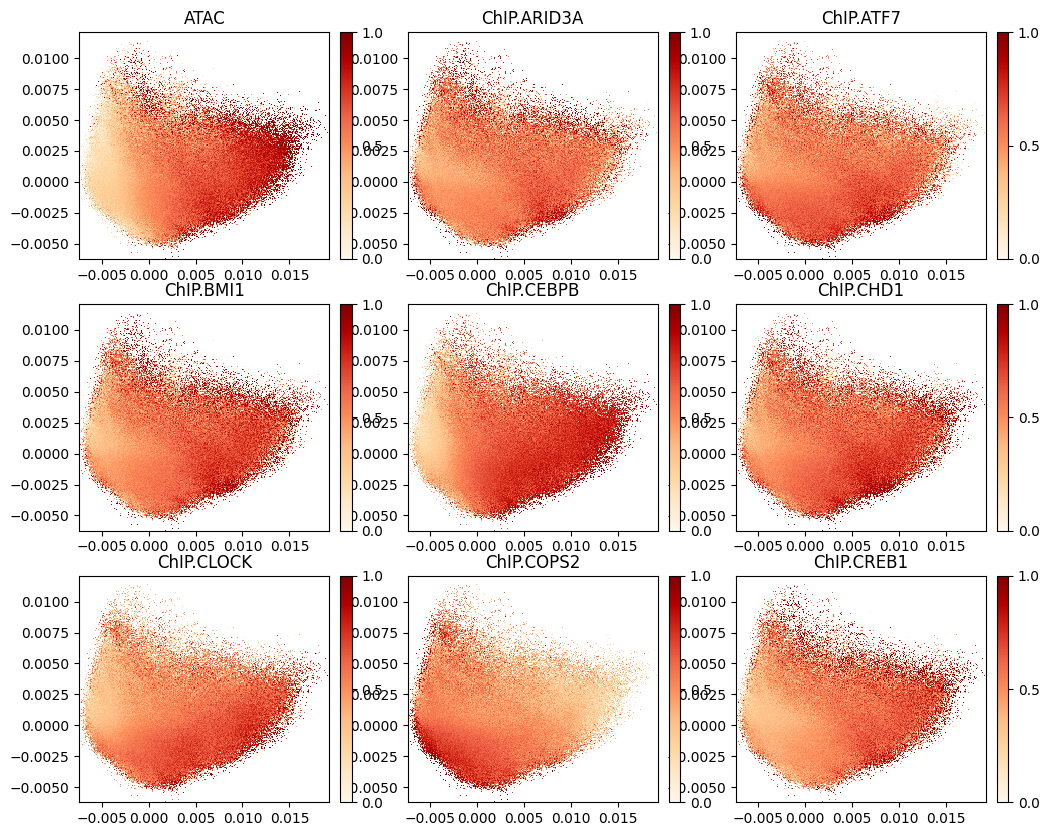

In [29]:
# Plot targets overlays
# Join ENCODE breast tissue metadata tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all targets

# List of targets
targets = db.track_metadata.assay.unique()
targets.sort()

# Show 9 plots as an example
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather ChIP-seq data for the specified target and apply the scaler
    overlay = db.get_track_overlay(
        target, ["PCA1", "PCA2"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        overlay,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("PCA-overlays.pdf", dpi=300)
plt.show()

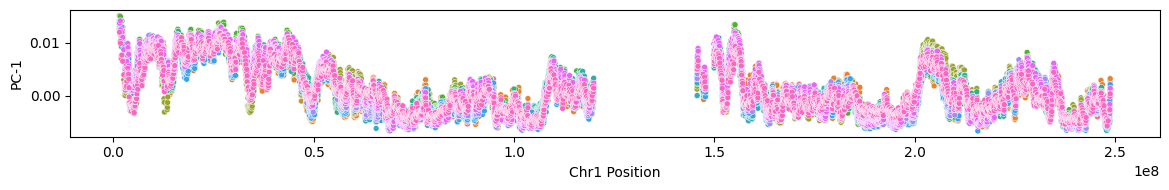

In [30]:
# Plot "Genome Browser" tracks for chr1
embeddings = db.get_embeddings(embeddings=["PCA1"], drop_bad_bins=False)
embeddings = embeddings[embeddings["chrom"] == "chr1"].copy()

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=embeddings, x="start", y="PCA1", size=1, hue="accession", ax=axis, legend=None
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("PC-1")

plt.savefig("PC1-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

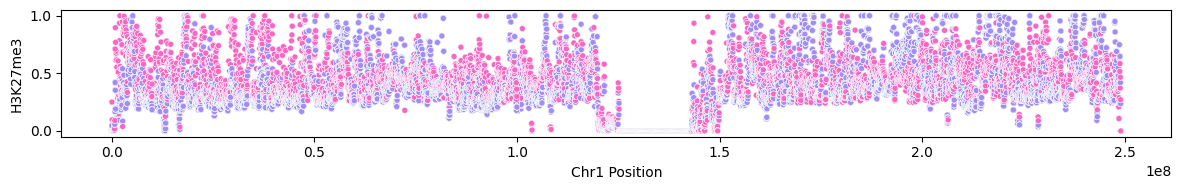

In [31]:
# Plot H3K27me3 signal along the same view
chip_signal = db.get_track_overlay(
    "ChIP.H3K27me3", ["PCA1"], drop_bad_bins=False, scaler=scale_signal
)

# Merge bin information
chip_signal = chip_signal.merge(db.bins)

# Filter to chr1
chip_signal = chip_signal[chip_signal["chrom"] == "chr1"]

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=chip_signal,
    x="start",
    y="signal",
    size=1,
    hue="accession",
    ax=axis,
    legend=None,
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("H3K27me3")

plt.savefig("H3K27me3-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

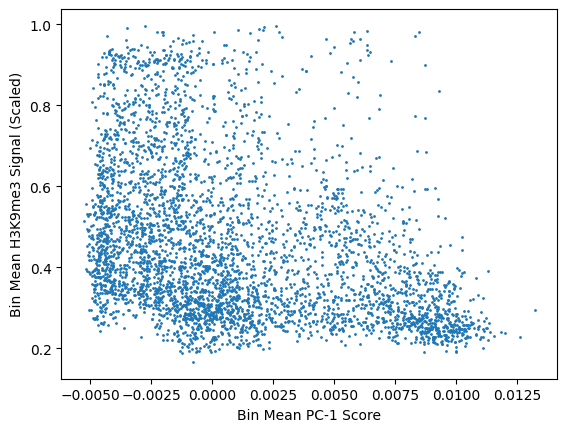

In [32]:
# Plot inverse relationship between PC-1 and H3K9me3 signal in chr1
plt.scatter(
    embeddings[["start", "PCA1"]].groupby("start").mean()["PCA1"],
    chip_signal[["start", "signal"]].groupby("start").mean()["signal"],
    s=1,
)

plt.xlabel("Bin Mean PC-1 Score")
plt.ylabel("Bin Mean H3K9me3 Signal (Scaled)")
plt.savefig("PC1-vs-H3K9me3-signal-chr1.pdf", dpi=300)
plt.show()